# Custom Transformations

In this notebook we will go over the basics of creating a custom transformation in Sigment, using the `Transform` base class.

To best understand this notebook, it is recommended that you read the [Using Transformations](https://nbviewer.jupyter.org/github/eonu/sigment/blob/master/notebooks/Using%20Transformations.ipynb) notebook first.

---

**Contents**:

- [General structure of a custom transformation class](#General-structure-of-a-custom-transformation-class)
- [Implementing a custom Laplacian white noise transformation](#Implementing-a-custom-Laplacian-white-noise-transformation)
  - [The Laplace distribution](#The-Laplace-distribution)
  - [Defining the transformation class](#Defining-the-transformation-class)
  - [Loading and viewing the original signal](#Loading-and-viewing-the-original-signal)
  - [Testing the new transformation class](#Testing-the-new-transformation-class)

In [1]:
import matplotlib.pyplot as plt
from librosa import load
from sigment import Transform
from utils import plot
plt.style.use('ggplot')

## General structure of a custom transformation class

A general custom transformation will be a subclass of the `Transform` base class, with the following structure:

```python
class CustomTransform(Transform):
    def __init__(self, *params, p=1., random_state=None):
        super().__init__(p, random_state)
        # 1. Validate and set your parameters as instance variables here
        
    def _transform(self, X, sr):
        X = self._val.signal(X)
        
        # 2. Validate the sample rate if it is required for your transformation
        sr = self._val.restricted_integer(sr, 'sr (sample rate)', lambda x: x > 0, 'positive')
        
        # 3. Sample values for your parameters here
        # 4. Apply the transformation to the signal here
        return X
```

The validations used in step 1 depend on the nature of the parameters used for the transformation, but these will normally be one of the [`float_value`](https://sigment.readthedocs.io/en/latest/sections/validations.html#sigment.internals.validator._Validator.float_value), [`integer_value`](https://sigment.readthedocs.io/en/latest/sections/validations.html#sigment.internals.validator._Validator.integer_value), [`one_of`](https://sigment.readthedocs.io/en/latest/sections/validations.html#sigment.internals.validator._Validator.one_of), or [`boolean`](https://sigment.readthedocs.io/en/latest/sections/validations.html#sigment.internals.validator._Validator.boolean) validations from the internal [validations class](https://sigment.readthedocs.io/en/latest/sections/validations.html).

If the transformation you are applying does not rely on the sample rate, then step 2 is not necessary.

In step 3, sampling from the [value range](https://nbviewer.jupyter.org/github/eonu/sigment/blob/master/notebooks/Using%20Transformations.ipynb#Value-ranges) of each parameter is performed. For a parameter `param`, assuming the `self.param` value range was set in step 1, the following should be performed in this step (for each parameter):

```python
# If the parameter is discrete (an integer)
param = self.random_state.randint(self.param[0], self.param[1] + 1)
# If the parameter is continuous (a real number)
param = self.random_state.uniform(*self.param)
```
  
The transformation applied in step 4 should then use the new sampled parameter values.

## Implementing a custom Laplacian white noise transformation

To demonstrate how to create a custom transformation class, we will now implement an additive Laplacian white noise transformation.

### The Laplace distribution

The [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution) is a continuous probability distribution that can be used to generate signal noise. The probability density function is given by:

$$p(x\ |\ \mu, b) = \frac{1}{2b} \exp\left(-\frac{|x - \mu|}{b}\right)$$

where $\mu\in\mathbb{R}$ and $b\in\mathbb{R}^+$ are the _location_ and _scale_ parameters, respectively.

As with [additive Gaussian white noise](https://en.wikipedia.org/wiki/Additive_white_Gaussian_noise) we set $\mu=0$ and vary $b$.

---

With a signal $\mathbf{x}=x_1,x_2,\ldots,x_T$ and noise $\mathbf{n}=n_1,n_2,\ldots,n_T$ where $n_i\sim\text{Laplace}(0, b)$, the signal with added noise is given by $\mathbf{x}' = \mathbf{x} + \mathbf{n}$.

### Defining the transformation class

We will now define a `LaplacianWhiteNoise` transformation class to apply additive Laplacian white noise to a signal.

In [2]:
class LaplacianWhiteNoise(Transform):
    """Applies additive Laplacian white noise to the signal."""

    def __init__(self, scale, p=1., random_state=None):
        super().__init__(p, random_state)

        # 1. Validate and set your parameters as instance variables here
        # As `scale` is real-valued, we use the `float_value` validator
        self.scale = self._val.float_value(
            scale, 'scale (scale parameter)',
            lambda a, b: 0. < a <= b, 'positive')

    def _transform(self, X, sr):
        X = self._val.signal(X)
        
        # 2. Validate the sample rate if it is required for your transformation
        # Not necessary for this transformation
        
        # 3. Sample values for your parameters here
        # As `scale` is real-valued, we sample from a uniform distribution
        scale = self.random_state.uniform(*self.scale)
        
        # 4. Apply the transformation to the signal here
        noise = self.random_state.laplace(loc=0, scale=scale, size=X.shape)
        return X + noise

### Loading and viewing the original signal

To observe the effects of the transformation we just created, we will load an audio signal from a sample WAV file and apply the transformation.

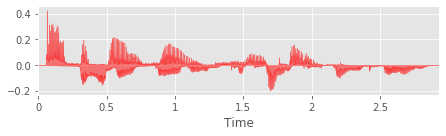

In [3]:
X, sr = load('assets/audio.wav', mono=False)
plot(X, sr=sr)

### Testing the new transformation class

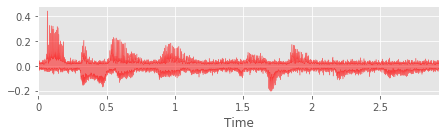

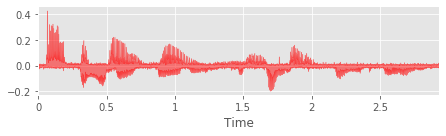

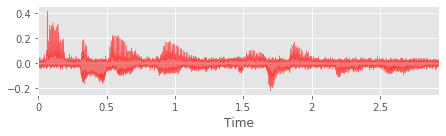

In [4]:
transform = LaplacianWhiteNoise(scale=(0.001, 0.01), random_state=0)
for X_aug in transform.generate(X, n=3):
    plot(X_aug, sr=sr)